In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

from amb_scripts.load_saved_info import *
from amb_scripts.plot_csfv3 import *

from dag_prf_utils.prfpy_functions import *
from dag_prf_utils.plot_functions import *
from dag_prf_utils.utils import *
from dag_prf_utils.mesh_maker import *

plot_cols = get_plot_cols()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


/home/daghlian/.conda/envs/ls_dag/lib/python3.9/site-packages/nilearn/glm/__init__.py:55: FutureWarning: The nilearn.glm module is experimental. It may change in any future release of Nilearn.
  warn('The nilearn.glm module is experimental. '


In [2]:
sub = 'sub-02'
ses_list = ['ses-1', 'ses-2']
qCSF_info = {}
for ses in ses_list:
    qCSF_info[ses] = amb_load_qcsf(sub, eye_list=['L', 'R'], ses=ses)

roi_fit = 'all'
fit_stage='iter'
csf_data = {}
prf_data = {}
for ses in ses_list:
    csf_data[ses] = amb_load_prf_params(
        sub=sub,
        task_list=['CSFLE', 'CSFRE'],
        model_list='csf',
        roi_fit=roi_fit, 
        fit_stage=fit_stage,
        ses=ses
    )
    prf_data[ses] = amb_load_prf_params(
        sub=sub,
        task_list=['pRFLE', 'pRFRE'],
        model_list='gauss',
        roi_fit=roi_fit, 
        fit_stage=fit_stage,
        ses=ses
    )


In [3]:

csf_obj = {}
prf_obj = {}
prf_obj_list = [] 
prf_id_list = []
for i_ses,ses in enumerate(ses_list):
    csf_obj[ses] = {}
    prf_obj[ses] = {}    
    
    for eye in ['L', 'R']:    
        csf_obj[ses][eye] = Prf1T1M(csf_data[ses][f'CSF{eye}E']['csf'], 'csf')
        
        prf_obj_list.append(csf_obj[ses][eye])
        prf_id_list.append(f'{eye}_{i_ses+1}_csf')
        
        prf_obj[ses][eye] = Prf1T1M(prf_data[ses][f'pRF{eye}E']['gauss'], 'gauss')
        
        prf_obj_list.append(prf_obj[ses][eye])
        prf_id_list.append(f'{eye}_{i_ses+1}_prf')   
        
prf_multi = PrfMulti(prf_obj_list, prf_id_list)

In [ ]:
# Ses vs eye ...
model = 'csf'
param = f'sf0'
prf_cols = {
    'L_1':'#9ecae1',
    'R_1':'#a1d99b',
    'L_2':'#3182bd',
    'R_2':'#31a354',
}
fig, ax = plt.subplots(4,1)
fig.set_size_inches(7,12)
fig.set_tight_layout('tight')
for i,ses in enumerate(['1', '2']):
    
    for eye in ['L', 'R']:
        eye_ses = f'{eye}_{ses}'
        vx_mask = prf_multi.return_vx_mask(
            {f'{eye_ses}_{model}-min-rsq':.1}
        )
        x = prf_multi.prf_obj[f'{eye_ses}_{model}'].pd_params[param][vx_mask]
        ax[i].hist(x, color=prf_cols[eye_ses], label=eye_ses, alpha=0.9)
    ax[i].legend()
    ax[i].set_xlabel(param)


for i,eye in enumerate(['L', 'R']):
    for _,ses in enumerate(['1', '2']):
    
        eye_ses = f'{eye}_{ses}'
        vx_mask = prf_multi.return_vx_mask(
            {f'{eye_ses}_{model}-min-rsq':.1}
        )
        x = prf_multi.prf_obj[f'{eye_ses}_{model}'].pd_params[param][vx_mask]
        ax[i+2].hist(x, color=prf_cols[eye_ses], label=eye_ses, alpha=0.9)
    ax[i+2].legend()
    ax[i+2].set_xlabel(param)



In [ ]:
prf_multi.id_list

PatsyError: Error evaluating factor: NameError: name 'rsq' is not defined
    rsq ~ C(eye) + C(ses) + C(eye):C(ses)
    ^^^

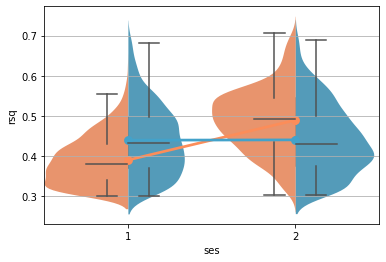

In [83]:

# Importing libraries
import statsmodels.api as sm
from statsmodels.formula.api import ols

def LE_RE_ses_violin(prf_multi, model, param, th=None, do_plot=True,):        
    if th is None:
        th = {'min-rsq':.1, 'max-ecc':5}
    # prfx = Prf1T1Mx2(prf_obj1=prfL, prf_obj2=prfR, id1='L', id2='R')
    vx_mask = prf_multi.return_vx_mask(th)
    p_dict = {}
    p_dict[param] = []
    p_dict['eye'] = []
    p_dict['ses'] = []
    # p_dict['model'] = []
    for eye in ['L', 'R']:
        for ses in ['1', '2']:
            # vx_mask = prf_multi.prf_obj[f'{eye}_{ses}_{model}'].return_vx_mask(th)
            this_p = prf_multi.prf_obj[f'{eye}_{ses}_{model}'].pd_params[param][vx_mask]
            p_dict[param].append(this_p)
            p_dict['eye'].append([eye]*len(this_p))
            p_dict['ses'].append([ses]*len(this_p))

    for key in p_dict.keys():                                                              
        p_dict[key] = np.concatenate(p_dict[key])                                          
    p_PD = pd.DataFrame(p_dict)    
    if do_plot:                                                        
        sns.violinplot(                                                                        
            x="ses", y=param, hue="eye",                                
            data=p_PD, palette=[plot_cols["LE"], plot_cols["RE"]],                     
            width=1, linewidth=0, split=True, inner=None,)                                     
        sns.boxplot(x="ses", y=param,                                            
                    hue="eye", palette=[plot_cols["LE"], plot_cols["RE"]],        
                    data=p_PD, showfliers = False, width=.5)
        sns.pointplot(
            x="ses", y=param, 
            hue="eye", palette=[plot_cols["LE"], plot_cols["RE"]],        
            data=p_PD)                               
        # # sns.despine(offset=10, trim=True)                                                    
        plt.gca().grid(True, which='both', axis="y")  
        plt.gca().get_legend().remove()

        #
        formula = f'{param} ~ C(eye) + C(ses) + C(eye):C(ses)'
        model = ols(formula, data=this_PD).fit()
        anova_table = sm.stats.anova_lm(model, typ=2)
        print(anova_table)

        # # plt.legend('off')                                         
        # plt.gca().set_ylim(0,5)                                                               
        # plt.gca().set_title(title)                                                               
        # y_max = plt.gca().get_ylim()[-1]
        # plt.gcf().set_size_inches(10,4)
        # dag_update_ax_fontsize(plt.gca(), 15)
        # for i,p in enumerate(roi_pval):
        #     plt.gca().text(i,y_max*.8,p,  color='red', fontsize=40)
        # # plt.gca().set_title(f'Rsq for {sub} (fit on AS0, test on AS1,AS2, including scotoma)') 
        
    return p_PD
this_PD = LE_RE_ses_violin(
    prf_multi=prf_multi, 
    model='csf', 
    param='rsq', th={'all-min-rsq':.3})
plt.figure()
this_PD = LE_RE_ses_violin(
    prf_multi=prf_multi, 
    model='csf', 
    param='sf0', th={'all-min-rsq':.1})

In [29]:


def LE_RE_ses_pd(prf_multi, model, param, th=None, do_plot=True, matched=True):        
    if th is None:
        th = {'all-min-rsq':.1}
    vx_mask = prf_multi.return_vx_mask(th)
    
    p_dict = {}
    p_dict[param] = []
    p_dict['eye'] = []
    p_dict['ses'] = []
    p_dict['vx_id'] = []

    # p_dict['model'] = []
    for eye in ['L', 'R']:
        for ses in ['1', '2']:
            # vx_mask = prf_multi.prf_obj[f'{eye}_{ses}_{model}'].return_vx_mask(th)
            this_p = prf_multi.prf_obj[f'{eye}_{ses}_{model}'].pd_params[param][vx_mask]
            # this_p = np.random.rand(len(this_p))
            p_dict[param].append(this_p)
            # this_
            p_dict['eye'].append([eye]*len(this_p))
            p_dict['ses'].append([ses]*len(this_p))
            p_dict['vx_id'].append(np.arange(len(this_p)))

    for key in p_dict.keys():                                                              
        p_dict[key] = np.concatenate(p_dict[key])                                          
    p_PD = pd.DataFrame(p_dict)    
    p_PD['eye'] = pd.Categorical(p_PD['eye'])
    p_PD['ses'] = pd.Categorical(p_PD['ses'])

    return p_PD



In [71]:
prf_multi.id_list

['L_1_csf',
 'L_1_prf',
 'R_1_csf',
 'R_1_prf',
 'L_2_csf',
 'L_2_prf',
 'R_2_csf',
 'R_2_prf']

sf0
[ 2.2683401  -1.24570022  0.0310666  -0.22764948]
                     sum_sq       df            F        PR(>F)
C(eye)         15017.503397      1.0  6313.691282  0.000000e+00
C(ses)            55.647392      1.0    23.395397  1.324970e-06
C(eye):C(ses)    105.268082      1.0    44.257035  2.925329e-11
Residual       77293.736513  32496.0          NaN           NaN



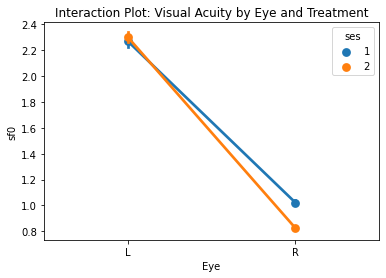

maxC
[35.37665524 19.42701262 -9.84608967  0.98564512]
                     sum_sq       df            F         PR(>F)
C(eye)         3.223999e+06      1.0  1492.457674  2.905600e-319
C(ses)         7.108043e+05      1.0   329.046455   3.564370e-73
C(eye):C(ses)  1.973352e+03      1.0     0.913507   3.391928e-01
Residual       7.019768e+07  32496.0          NaN            NaN



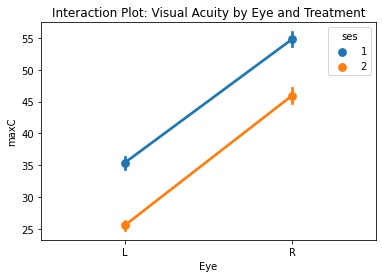

width_r
[ 1.49648696  0.53395908  0.08798212 -0.01715702]
                     sum_sq       df            F        PR(>F)
C(eye)          2242.701027      1.0  3143.691410  0.000000e+00
C(ses)            51.227582      1.0    71.807926  2.470526e-17
C(eye):C(ses)      0.597925      1.0     0.838138  3.599367e-01
Residual       23182.559311  32496.0          NaN           NaN



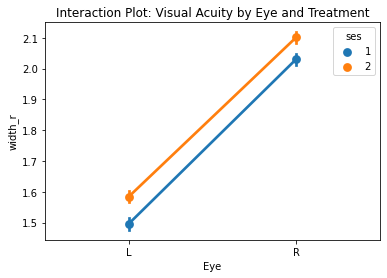

rsq
[ 0.24393959  0.06450206  0.11323787 -0.13184488]
                   sum_sq       df            F         PR(>F)
C(eye)           0.016392      1.0     1.235147   2.664166e-01
C(ses)          18.189843      1.0  1370.613850  6.647100e-294
C(eye):C(ses)   35.309365      1.0  2660.578542   0.000000e+00
Residual       431.264522  32496.0          NaN            NaN



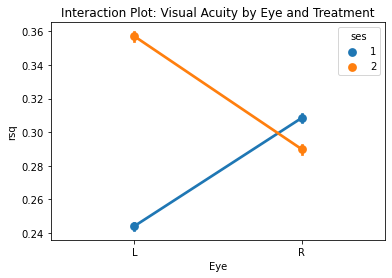

In [68]:
roi = 'all'
roi_mask = amb_load_roi(sub, roi)
model = 'csf'
for param in ['sf0', 'maxC', 'width_r', 'sfmax', 'rsq']:
    formula = f'{param} ~ C(eye) + C(ses) + C(eye):C(ses)'
    # param = 'sfmax'
    this_PD = LE_RE_ses_pd(
        prf_multi=prf_multi, 
        model='csf', 
        param=param, th={'all-min-rsq':.1, 'roi':roi_mask})
    model = ols(formula, data=this_PD).fit()
    anova_table = sm.stats.anova_lm(model, typ=2)
    print(param)
    print(model._results.params)
    print(anova_table)
    print('')
    plt.figure()
    # # Plotting box plots
    # sns.boxplot(x='eye', y=param, hue='ses', data=this_PD)
    # plt.title(f'{param} by Eye and Treatment')
    # plt.xlabel('Eye')
    # plt.ylabel(param)
    # plt.show()

    # Plotting interaction plots
    sns.pointplot(x='eye', y=param, hue='ses', data=this_PD)
    plt.title('Interaction Plot: Visual Acuity by Eye and Treatment')
    plt.xlabel('Eye')
    plt.ylabel(param)
    plt.show()    


ecc
[1.965343   0.32315158 0.15498946 0.13650215]
                     sum_sq       df           F         PR(>F)
C(eye)           613.243735      1.0  475.943188  5.314305e-104
C(ses)           199.494859      1.0  154.829497   2.223756e-35
C(eye):C(ses)     18.646812      1.0   14.471934   1.427923e-04
Residual       20626.003175  16008.0         NaN            NaN



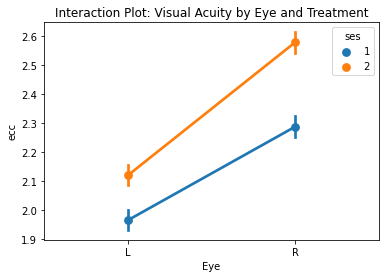

KeyError: 'L_1_<statsmodels.regression.linear_model.RegressionResultsWrapper object at 0x7fa8d3e7a9a0>'

In [70]:
roi = 'all'
roi_mask = amb_load_roi(sub, roi)
model = 'prf'
for param in ['ecc', 'rsq', 'rsq']:
    formula = f'{param} ~ C(eye) + C(ses) + C(eye):C(ses)'
    # param = 'sfmax'
    this_PD = LE_RE_ses_pd(
        prf_multi=prf_multi, 
        model=model, 
        param=param, th={'all-min-rsq':.1,'all-max-ecc':5, 'roi':roi_mask})
    model = ols(formula, data=this_PD).fit()
    anova_table = sm.stats.anova_lm(model, typ=2)
    print(param)
    print(model._results.params)
    print(anova_table)
    print('')
    plt.figure()
    # # Plotting box plots
    # sns.boxplot(x='eye', y=param, hue='ses', data=this_PD)
    # plt.title(f'{param} by Eye and Treatment')
    # plt.xlabel('Eye')
    # plt.ylabel(param)
    # plt.show()

    # Plotting interaction plots
    sns.pointplot(x='eye', y=param, hue='ses', data=this_PD)
    plt.title('Interaction Plot: Visual Acuity by Eye and Treatment')
    plt.xlabel('Eye')
    plt.ylabel(param)
    plt.show()    


,sum_sq,df,F,PR(>F)
C(eye),2242.701027,1.0,3143.691410,0.000000e+00
C(ses),51.227582,1.0,71.807926,2.470526e-17
C(eye):C(ses),0.597925,1.0,0.838138,3.599367e-01
Residual,23182.559311,32496.0,NaN,NaN


In [55]:
# model._results.__dict__.keys()


dict_keys(['params', 'model', 'k_constant', '_data_attr', '_data_in_cache', 'normalized_cov_params', '_use_t', '_cache', '_wexog_singular_values', 'df_model', 'df_resid', 'cov_type', 'cov_kwds'])

In [26]:




# this_PD = LE_RE_ses_violin(
#     prf_multi=prf_multi, 
#     model='csf', 
#     param='sfmax', th={'min-rsq':.1}, do_plot = False)
# # Performing two-way ANOVA
# model = ols(
#     'height ~ C(Fertilizer) + C(Watering) +\
#     C(Fertilizer):C(Watering)', data=df).fit()
# sm.stats.anova_lm(model, typ=2)

In [27]:
# Perform the ANOVA
anova_table = sm.stats.anova_lm(model, typ=2)
print(anova_table)






                   sum_sq      df         F    PR(>F)
C(eye)           0.064714     1.0  0.781748  0.376674
C(ses)           0.146757     1.0  1.772830  0.183128
C(eye):C(ses)    0.397431     1.0  4.801000  0.028516
Residual       262.581284  3172.0       NaN       NaN


In [ ]:
prf_multi.id_list

In [ ]:
sub_list = ['sub-01', 'sub-02']
roi_fit = 'all'


In [ ]:
# prf_data = {}
# csf_data = {}
# real_tc = {}
# pred_tc = {}
# pred_tc = {}
prf_objs = {}
all_prf_objs = {}
for sub in sub_list:

    # LOAD USEFUL INFORMATION
    prf_data = amb_load_prf_params(
        sub=sub,
        task_list=['pRFLE', 'pRFRE'],
        model_list='gauss',
        roi_fit=roi_fit,            
    )

    csf_data = amb_load_prf_params(
        sub=sub,
        task_list=['CSFLE', 'CSFRE'],
        model_list='csf',
        roi_fit=roi_fit,            
    )

    # real_tc[sub] = amb_load_real_tc(sub=sub, task_list=['pRFLE', 'pRFRE', 'CSFLE', 'CSFRE'])
    # pred_tc[sub] = amb_load_pred_tc(sub=sub, task_list=['pRFLE', 'pRFRE'], model_list='gauss')
    # pred_tc[sub] |= amb_load_pred_tc(sub=sub, task_list=['CSFRE', 'CSFLE'], model_list='csf')

    # Enter into prf objects:
    prf_obj_list = []
    prf_id_list = []
    prf_obj = {}
    model = 'gauss'
    for task in ['pRFLE', 'pRFRE']:    
        prf_obj[task] = {}    
        prf_obj[task][model] = Prf1T1M(prf_data[task][model], model)
        prf_obj_list.append(Prf1T1M(prf_data[task][model], model))
        prf_id_list.append(task)

    model = 'csf'
    for task in ['CSFLE', 'CSFRE']:    
        prf_obj[task] = {}    
        prf_obj[task][model] = Prf1T1M(csf_data[task][model], model)

        prf_obj_list.append(Prf1T1M(csf_data[task][model], model, fixed_hrf=True))
        prf_id_list.append(task)

    prf_objs[sub] = prf_obj
    all_prf_objs[sub] = PrfMulti(prf_obj_list, prf_id_list)

In [ ]:

def mini_show_csf_param(param, min_rsq, bins):
    for sub in sub_list:
        plt.figure()
        all_prf_objs[sub].rapid_hist(
            f'CSFLE-{param}', label=f'LE-{param}', color=plot_cols['LE'], bins=bins,ax=plt.gca(),
            th={'CSFLE-min-rsq':min_rsq})
        all_prf_objs[sub].rapid_hist(
            f'CSFRE-{param}', label=f'RE-{param}', color=plot_cols['RE'], bins=bins,ax=plt.gca(),
            th={'CSFRE-min-rsq':min_rsq})
        plt.title(sub)

        plt.figure()
        all_prf_objs[sub].rapid_p_corr(
            f'CSFLE-{param}', f'CSFRE-{param}', ax=plt.gca(),do_line=True,do_id_line=True,
            th={'CSFLE-min-rsq':min_rsq, 'CSFRE-min-rsq':min_rsq})
        plt.title(sub)


In [ ]:
min_rsq = .2
bins = np.linspace(0,6,10)
param = 'sf0'
mini_show_csf_param(param, min_rsq, bins)

In [ ]:
min_rsq = .1
bins = np.linspace(0,6,20)
param = 'width_r'
mini_show_csf_param(param, min_rsq, bins)

In [ ]:
# prf_obj['pRFLE']['gauss'].rapid_p_corr('ecc', 'size_1', th={'min-rsq':.1, 'max-ecc':5}, do_line=True)

# plt.figure()
# prf_obj['pRFRE']['gauss'].rapid_p_corr('ecc', 'size_1', th={'min-rsq':.1, 'max-ecc':5}, do_line=True)

# plt.figure()

all_prf_obj2.rapid_p_corr(
    'pRFLE-ecc', 'pRFLE-size_1', do_line=True, do_scatter=False, line_label='LE',
    th={'pRFLE-min-rsq':.1, 'pRFLE-max-ecc':5,})

all_prf_obj2.rapid_p_corr(    
    'pRFRE-ecc', 'pRFRE-size_1',ax=plt.gca(), do_line=True, do_scatter=False, line_col='b', line_label='RE',
    th={'pRFRE-min-rsq':.1, 'pRFRE-max-ecc':5,})

In [ ]:
# csf_tc_plotter(
#     real_tc=real_tc['CSFLE'], 
#     pred_tc=pred_tc['CSFLE'], 
#     params=prf_obj['CSFLE']['csf'].prf_params_np, idx=[8,10])
from amb_scripts.plot_csfv3 import *


In [ ]:
amb_plotter = AmbPlotter(
    sub=sub, 
    real_tc=real_tc['CSFLE'],
    csf_params = csf_data['CSFLE']['csf'],
    
    )

In [ ]:
amb_plotter.csf_tc_plot(idx=8, time_pt=None)

In [ ]:
np.where(prf_obj['CSFLE']['csf'].prf_params_np[:,-1]>0.1)

In [ ]:
# # # all_prf_obj.rapid_hist(ax=plt.gca(), px='pRFLE-hrf_deriv', alpha=0.5)
# # # all_prf_obj.rapid_hist(ax=plt.gca(), px='pRFRE-hrf_deriv', alpha=0.5)
# # all_prf_obj.rapid_hist(ax=plt.gca(), px='CSFRE-hrf_deriv', alpha=0.5)
# # all_prf_obj.rapid_hist(ax=plt.gca(), px='CSFLE-hrf_deriv', alpha=0.5)

# all_prf_obj.rapid_p_corr(
#     'CSFLE-rsq',
#     'CSFRE-rsq', 
#     th={'CSFLE-min-rsq':.1, 'CSFRE-min-rsq':.1}, 
#     do_line=True, line_col='r', dot_col='k', dot_alpha=.5)

In [ ]:
# prf_dE = Prf1T1Mx2(prf_obj['pRFLE']['gauss'], prf_obj['pRFRE']['gauss'], id1='prfLE', id2='prfRE')
# csf_dE = Prf1T1Mx2(prf_obj['CSFLE']['csf'], prf_obj['CSFRE']['csf'], id1='csfLE', id2='csfRE')
# le_dT =  Prf1T1Mx2(prf_obj['pRFLE']['gauss'], prf_obj['CSFLE']['csf'], id1='prfLE', id2='csfLE')
# re_dT =  Prf1T1Mx2(prf_obj['pRFRE']['gauss'], prf_obj['CSFRE']['csf'], id1='prfRE', id2='csfRE')

In [ ]:
# # prf_dE.rapid_p_corr(
# #     'prfLE-hrf_deriv',
# #     'prfRE-hrf_deriv'
# # )
# # plt.figure()
# # csf_dE.rapid_p_corr(
# #     'csfLE-hrf_deriv',
# #     'csfRE-hrf_deriv'
# # )

# # plt.figure()
# # le_dT.rapid_p_corr(
# #     'csfLE-hrf_deriv',
# #     'prfLE-hrf_deriv'
# # )

# roi = amb_load_roi(sub, 'demo-5000000')
# plt.figure()
# re_dT.rapid_p_corr(
#     'prfRE-hrf_deriv',
#     'csfRE-hrf_deriv',
#     th={'all-min-rsq':.3, 'roi':roi},
# )

In [ ]:
fs = FSMaker(sub, fs_dir)
model = 'gauss'
# POLAR 
for task in task_list:
    # fs.add_surface(
    #     data = prf_obj[task][model].pd_params['pol'],
    #     surf_name = f'{sub}-{task}-{model}-pol',    
    #     vmin = -np.pi, vmax=np.pi , # min and max values of polar anlge 
    #     data_mask=prf_obj[task][model].return_vx_mask({'min-rsq':.1}),
    #     cmap = 'hsv_hsv', # using hsv for polar angle, can use something else...
    # )
    # POL CLOCK
    clock_val = dag_pol_to_clock(prf_obj[task][model].pd_params['pol'])
    fs.add_surface(
        data = clock_val,
        surf_name = f'{sub}-{task}-{model}-pol-clock',    
        vmin = 0, vmax=12, # min and max values of polar anlge 
        data_mask=prf_obj[task][model].return_vx_mask({'min-rsq':.1}),
        cmap = 'magma_viridis', # using hsv for polar angle, can use something else...
        cmap_nsteps=20
    )    
# model = 'csf'
# for task in ['CSFLE', 'CSFRE']:
#     fs.add_surface(
#         data = clock_val,
#         surf_name = f'{sub}-{task}-{model}-pol-clock',    
#         vmin = 0, vmax=12, # min and max values of polar anlge 
#         data_mask=prf_obj[task][model].return_vx_mask({'min-rsq':.1}),
#         cmap = 'twilight', # using hsv for polar angle, can use something else...
#         cmap_nsteps=20
#     )        


# # d_val
# model = 'norm'
# for task in task_list:
#     fs.add_surface(
#         data = prf_obj[task][model].pd_params['d_val'],
#         surf_name = f'{sub}-{task}-{model}-d_val',    
#         vmin = 0, vmax=100, # min and max values of polar anlge 
#         data_mask=prf_obj[task][model].return_vx_mask({'min-rsq':.1}),
#         cmap = 'jet', # using hsv for polar angle, can use something else...
#     )


# # b_val
# model = 'norm'
# for task in task_list:
#     fs.add_surface(
#         data = prf_obj[task][model].pd_params['b_val'],
#         surf_name = f'{sub}-{task}-{model}-b_val',    
#         vmin = 0, vmax=100, # min and max values of polar anlge 
#         data_mask=prf_obj[task][model].return_vx_mask({'min-rsq':.1}),
#         cmap = 'viridis', # using hsv for polar angle, can use something else...
#     )


# size_1
# model = 'gauss'
# for task in task_list:
#     fs.add_surface(
#         data = prf_obj[task][model].pd_params['size_1'],
#         surf_name = f'{sub}-{task}-{model}-size_1',    
#         vmin = 0, vmax=10, # min and max values of polar anlge 
#         data_mask=prf_obj[task][model].return_vx_mask({'min-rsq':.1}),
#         cmap = 'ecc', # using hsv for polar angle, can use something else...
#     )


In [ ]:
fs.open_fs_surface(
    fs.surf_list, 
    mesh='inflated', 
    # roi_list=['v1custom', 'v2custom', 'v3custom', 'LOcustom']
    )

In [ ]:
dag_stack_cmaps(['magma','viridis'])#, save_cmap=True)#, 'magma_r'])
# a = dag_get_cmap('viridis_magmarev')

# plt.imshow(
#     np.linspace(0,1,1000)*np.ones((100,1000)),
#     cmap=a, vmin=0, vmax=1)

# dag_make_custom_cmap(
#     ['green', 'green'], cmap_name='blah', save_cmap=True
# )


In [ ]:
# dag_get_cmap('blah')
dag_stack_cmaps(['plasma_r'])

***

In [ ]:
# LOAD AND SAVE #
sub_list = [1,2,3,4,6]
dAS = {}
sAS = {}
for i,v in enumerate(sub_list):
    sub = f'sub-{v:02}'
    dAS[sub] = {}
    sAS[sub] = {}    
    print(sub)
    for task in ['AS1', 'AS2']:
        dAS[sub][task] = ScotShiftPlot(sub=sub, task_list=['AS0', task], model='gauss', sim_or_data='data')
        sAS[sub][task] = {}
        for model in ['gauss', 'norm']:
            sAS[sub][task][model] = ScotShiftPlot(sub=sub, task_list=['AS0', task], model=model, sim_or_data='sim')

In [ ]:
# LOAD AND SAVE #
sub_list = [1,2,3,4,6]

for i,v in enumerate(sub_list):
    sub = f'sub-{v:02}'
    for task in ['AS1', 'AS2']:
        plt.figure()
        dAS[sub][task].
        for model in ['gauss', 'norm']:

In [ ]:
sub = 'sub-01'
task_list = ['AS0', 'AS1']
dAS2g = ScotShiftPlot(sub=sub, task_list=task_list, model='gauss', sim_or_data='data')
sAS2g = ScotShiftPlot(sub=sub, task_list=task_list, model='gauss', sim_or_data='sim')
sAS2n = ScotShiftPlot(sub=sub, task_list=task_list, model='norm', sim_or_data='sim')


In [ ]:

sub_list = [1,2,3,4,6]
sub_task_rsq_max = {}
dAS = {}
sAS = {}
for i,v in enumerate(sub_list):
    sub = f'sub-{v:02}'
    print('sub')
    sub_task_rsq_max[sub] = {}
    for task in ['AS1', 'AS2']:
        dASXg = ScotShiftPlot(sub=sub, task_list=['AS0', task], model='gauss', sim_or_data='data')
        # sAS[task] = dASXg
        sub_task_rsq_max[sub][task] = {}
        for model in ['gauss', 'norm']:
            sASXm = ScotShiftPlot(sub=sub, task_list=['AS0', task], model=model, sim_or_data='sim')

            sub_task_rsq_max[sub][task][model] = []
            for rsq_max in np.r_[.1:1:.01]:
                vx_mask = dASXg.return_vx_mask({'all-min-rsq':.1, 'all-max-ecc':5})            
                vx_mask&= sASXm.return_vx_mask({'all-bound-rsq':[.1,rsq_max], 'all-max-ecc':5})
                if np.sum(vx_mask)<500:
                    corr = np.NaN
                else:
                    corr = dag_get_corr(
                        dASXg.pd_params['diff']['d2s_centre'][vx_mask],
                        sASXm.pd_params['diff']['d2s_centre'][vx_mask])
                sub_task_rsq_max[sub][task][model].append(corr)

In [ ]:
sub_list = [1,2,3,4,6]
AS_m = {'AS1':'+', 'AS2':'^'}
m_col = {'gauss':'g', 'norm':'r'}

for i,v in enumerate(sub_list):
    plt.figure()
    sub = f'sub-{v:02}'
    for task in ['AS1', 'AS2']:
        for model in ['gauss', 'norm']:
            plt.plot(sub_task_rsq_max[sub][task][model],f'-{AS_m[task]}{m_col[model]}', label=f'{task}-{model}')
    plt.legend()


In [ ]:
i_corr = []
for i in np.r_[.2:1:.01]:
    vx_mask = dAS2g.return_vx_mask(th={'all-min-rsq':.1,'all-max-ecc':5})
    vx_mask&= sAS2n.return_vx_mask(th={'all-bound-rsq':[.1,i], 'all-max-ecc':5})
    corr = dag_get_corr(
        dAS2g.pd_params['diff']['d2s_centre'][vx_mask],
        sAS2n.pd_params['diff']['d2s_centre'][vx_mask])
    i_corr.append(corr)
    # print(f'For {vx_mask.sum()} vx, & max rsq={i:.2f}, corr={corr:.3f}')

In [ ]:
plt.plot(i_corr)
plt.plot()

In [ ]:
sim_prf_obj = ScotShiftPlot(                                                         
    sub='sub-01',task_list=['AS0', 'AS1'],model='norm',
    sim_or_data='sim')  

In [ ]:
# Check the correlations: 
rsq_th = 0.1
ecc_th = 5
d2_corr = {
    'gauss' : np.zeros((6,2)), 
    'norm' : np.zeros((6,2)),
}
D_d2s_change = {}
S_d2s_change = {}
sub_list = [1,2,3,4,6]
for i,v in enumerate(sub_list):
    print('')
    sub = f'sub-{v:02}'
    D_d2s_change[sub] = {}
    for i_t,task in enumerate(['AS1', 'AS2']):
        D_d2s_change[sub][task] = {}
        S_d2s_change[sub][task] = {}
        for model in ['gauss', 'norm']:
            data_prf_obj = ScotShiftPlot( # ALWAYS GAUSS                                                        
                sub=sub,task_list=['AS0', task], model='gauss',
                sim_or_data='data')
            sim_prf_obj = ScotShiftPlot(                                                         
                sub=sub,task_list=['AS0', task],model=model,
                sim_or_data='sim')
            D_d2s_change[sub][task] = {}
            S_d2s_change[sub][task] = {}            
            this_vx_mask = sim_prf_obj.return_vx_mask({'all-min-rsq':rsq_th, 'all-max-ecc':ecc_th})
            this_vx_mask &= data_prf_obj.return_vx_mask({'all-min-rsq':rsq_th, 'all-max-ecc':ecc_th})                                   
            
            this_corr = np.corrcoef(
                data_prf_obj.pd_params['diff']['d2s_centre'][this_vx_mask],
                sim_prf_obj.pd_params['diff']['d2s_centre'][this_vx_mask],
            )[0,-1]
            d2_corr[model][i,i_t] = this_corr
            print(f'{sub}-{task}-{model: >5}: corr={this_corr:.3f}')

In [ ]:
# Check the correlations: 
rsq_th = 0.1
ecc_th = 5
d2_corr = {
    'gauss' : np.zeros((6,2)), 
    'norm' : np.zeros((6,2)),
}
D_d2s_change = {}
S_d2s_change = {}
sub_list = [1,2,3,4,6]
for i,v in enumerate(sub_list):
    print('')
    sub = f'sub-{v:02}'
    D_d2s_change[sub] = {}
    for i_t,task in enumerate(['AS1', 'AS2']):
        D_d2s_change[sub][task] = {}
        S_d2s_change[sub][task] = {}
        for model in ['gauss', 'norm']:
            data_prf_obj = ScotShiftPlot( # ALWAYS GAUSS                                                        
                sub=sub,task_list=['AS0', task], model='gauss',
                sim_or_data='data')
            sim_prf_obj = ScotShiftPlot(                                                         
                sub=sub,task_list=['AS0', task],model=model,
                sim_or_data='sim')
            D_d2s_change[sub][task] = {}
            S_d2s_change[sub][task] = {}            
            this_vx_mask = sim_prf_obj.return_vx_mask({'all-min-rsq':rsq_th, 'all-max-ecc':ecc_th})
            this_vx_mask &= data_prf_obj.return_vx_mask({'all-min-rsq':rsq_th, 'all-max-ecc':ecc_th})                                   
            
            this_corr = np.corrcoef(
                data_prf_obj.pd_params['diff']['d2s_centre'][this_vx_mask],
                sim_prf_obj.pd_params['diff']['d2s_centre'][this_vx_mask],
            )[0,-1]
            d2_corr[model][i,i_t] = this_corr
            print(f'{sub}-{task}-{model: >5}: corr={this_corr:.3f}')

In [ ]:
sub = 'sub-01'
G0_d = ScotPrf1T1M(sub=sub, task='AS0', model='gauss', sim_or_data='data')
G1_d = ScotPrf1T1M(sub=sub, task='AS1', model='gauss', sim_or_data='data')
# G2_d = ScotPrf1T1M(sub=sub, task='AS2', model='gauss', sim_or_data='data')
# N0_d = ScotPrf1T1M(sub=sub, task='AS0', model='norm' , sim_or_data='data')
# N1_d = ScotPrf1T1M(sub=sub, task='AS1', model='norm' , sim_or_data='data')
# N2_d = ScotPrf1T1M(sub=sub, task='AS2', model='norm' , sim_or_data='data')


In [ ]:
G2_d = ScotPrf1T1M(sub=sub, task='AS2', model='gauss', sim_or_data='data')

In [ ]:

G0_s = ScotPrf1T1M(sub=sub, task='AS0', model='gauss', sim_or_data='sim')
G1_s = ScotPrf1T1M(sub=sub, task='AS1', model='gauss', sim_or_data='sim')
# G2_s = ScotPrf1T1M(sub=sub, task='AS2', model='gauss', sim_or_data='sim')
# N0_s = ScotPrf1T1M(sub=sub, task='AS0', model='norm' , sim_or_data='sim')
N1_s = ScotPrf1T1M(sub=sub, task='AS1', model='norm' , sim_or_data='sim')
N2_s = ScotPrf1T1M(sub=sub, task='AS2', model='norm' , sim_or_data='sim')


In [ ]:
N0_s = ScotPrf1T1M(sub=sub, task='AS0', model='norm' , sim_or_data='sim')

In [ ]:
G0_d.rapid_hist('rsq')
G1_d.rapid_hist(ax=plt.gca(), param='rsq', alpha=0.5)

In [ ]:
G0_s.rapid_hist('rsq')
G1_s.rapid_hist(ax=plt.gca(), param='rsq', alpha=0.5)
N0_s.rapid_hist(ax=plt.gca(), param='rsq', alpha=0.5)
N1_s.rapid_hist(ax=plt.gca(), param='rsq', alpha=0.5)

In [ ]:
G1s_comp = Prf1T1Mx2(G0_s, G1_s, id1='G0_s', id2='G1_s')
N1s_comp = Prf1T1Mx2(N0_s, N1_s, id1='N0_s', id2='N1_s')
G1d_comp = Prf1T1Mx2(G0_d, G1_d, id1='G0_d', id2='G1_d')


In [ ]:
G1_s.rapid_scatter({'bound-rsq':[.3,.5]})

In [ ]:
G1s_comp.rapid_p_corr()

In [ ]:
comp = Prf1T1Mx2(
    N0_s, N1_s, id1='N0_s', id2='N1_s',
)
comp.rapid_p_corr('N0_s-ecc', 'N1_s-ecc')

In [ ]:
comp = Prf1T1Mx2(
    G0_d, G1_d, id1='G0_d', id2='G1_d',
)
comp.rapid_p_corr('G0_d-ecc', 'G1_d-ecc')

In [ ]:
vx_mask = 

In [ ]:
P_model_dict = {

    'G0_d': G0_d,
    'G1_d': G1_d,
    'G2_d': G2_d,
    'N0_d': N0_d,
    'N1_d': N1_d,
    'N2_d': N2_d,
    #
    'G0_s': G0_s,
    'G1_s': G1_s,
    'G2_s': G2_s,
    'N0_s': N0_s,
    'N1_s': N1_s,
    'N2_s': N2_s,    
}

In [ ]:
roi_mask = get_roi(sub, 'V1_exvivo')
s_id1 = 'N0_s'
s_id2 = 'N2_s'
d_id1 = 'G0_d'
d_id2 = 'G2_d'



fig,axs = plt.subplots(1)
fig.set_size_inches(10,10)
sim2 = Prf1T1Mx2(
    P_model_dict[s_id1],
    P_model_dict[s_id2],
    id1=s_id1, id2=s_id2)

sim2.rapid_arrow(th={'all-min-rsq':.1, 'roi':roi_mask, 'all-max-ecc':5}, arrow_col='angle')



fig,axs = plt.subplots(1)
fig.set_size_inches(10,10)
data2 = Prf1T1Mx2(
    P_model_dict[d_id1],
    P_model_dict[d_id2],
    id1=d_id1, id2=d_id2)
data2.rapid_arrow(th={'all-min-rsq':.1, 'roi':roi_mask, 'all-max-ecc':5}, arrow_col='angle')


In [ ]:
sub = 'sub-01'
task_list = ['AS0', 'AS1', 'AS2']
model_list = ['gauss', 'norm']
data_tc = load_data_tc(sub=sub, task_list=task_list)
d_pred_tc = load_data_prf(sub=sub, task_list=task_list, model_list=model_list, var_to_load='preds')
sim_tc = load_sim_tc(sub=sub, task_list=task_list, model_list=model_list)
s_pred_tc = load_sim_prf(sub=sub, task_list=task_list, model_list=model_list, var_to_load='preds')

In [ ]:
sim_tc = load_sim_tc(sub=sub, task_list=task_list, model_list=model_list)

In [ ]:
fig,ax = plt.subplots(1)
fig.set_size_inches(5,11)


In [ ]:
# Test whether subject stuff has been done: 
# -> [1] check for PSC 
# -> [2] check for 
source_data_dir = os.getenv("DIR_DATA_SOURCE")
derivatives_dir = os.getenv("DIR_DATA_DERIV")
default_prf_dir = opj(derivatives_dir, 'prf')
default_prf_xpred_dir = opj(derivatives_dir, 'prf_xpred')
default_ses = 'ses-1'
from dag_prf_utils.utils import *
def s0_checker(s, sub, **kwargs):
    roi_fit = kwargs.get('roi_fit', 'all')
    fit_stage = kwargs.get('fit_stage', 'iter')
    task = kwargs.get('task', '')
    model = kwargs.get('model', '')
    this_prf_dir = opj(default_prf_dir, sub, default_ses)
    this_xpred_dir = opj(default_prf_xpred_dir, sub, default_ses)
    if s=='s1':
        this_path = dag_find_file_in_folder(
            [sub, hyphen_parse('task', task), 'hemi-LR', 'desc-avg_bold', '.npy'], 
            this_prf_dir, return_msg=None)    
    elif 's2' in s:
        this_path = dag_find_file_in_folder(
            [sub, hyphen_parse('task', task), 'gauss', roi_fit, fit_stage, '.pkl'], 
            this_prf_dir, return_msg=None,)
    elif s=='s3':
        this_path = dag_find_file_in_folder(
            [sub, hyphen_parse('task', task), 'norm', roi_fit, fit_stage, '.pkl'], 
            this_prf_dir, return_msg=None)    
    elif s=='s4':
        this_path = dag_find_file_in_folder(
            [sub, hyphen_parse('task', task), model, roi_fit, '.npy'], 
            this_xpred_dir, return_msg=None)    
    elif s=='s5':
        this_path = dag_find_file_in_folder(
            [sub, hyphen_parse('task', task), model, roi_fit, fit_stage, '.pkl'], 
            this_xpred_dir, return_msg=None)        
    if this_path is None:
        print(f'{s}, {sub}, {task}, {model}, NOT FOUND')
        sN_done = False
    else:
        sN_done = True
    
    return sN_done

        
            
for i in np.arange(1, 7):
    if i==5:
        continue
    sub = f'sub-{i:02}'
    for task in ['AS0', 'AS1', 'AS2']:
        s0_checker('s2', sub, task=task, )#model='gauss')
        s0_checker('s3', sub, task=task, )#model='gauss')
        # s0_checker('s4', sub, task=task, model='gauss')
        # s0_checker('s4', sub, task=task, model='norm')

        s0_checker('s5', sub, task=task, model='norm')
        s0_checker('s5', sub, task=task, model='gauss')
        # s0_checker('s2b', sub, task=task, )#model='gauss')

In [ ]:
for i in np.arange(1, 7):
    sub = f'sub-{i:02}'
    for task in ['AS0', 'AS1', 'AS2']:
        for model in ['gauss', 'norm']:
            try:
                ScotPrf1T1M(sub, task, model, sim_or_data='sim')
                print(f'{sub}, {task}, {model}')
            except:
                continue


In [ ]:
fs_dir = '/data1/projects/dumoulinlab/Lab_members/Marcus/projects/pilot1/derivatives/freesurfer'
from dag_prf_utils.mesh_maker import FSMaker
from dag_prf_utils.blender_tools import BlendMaker



In [ ]:
sub = 'sub-01'
prf_obj = ScotPrf1T1M(sub=sub, task='AS0', model='gauss')
fs = FSMaker(sub, fs_dir)


In [ ]:
sub = 'sub-01'
prf_obj = ScotPrf1T1M(sub=sub, task='AS0', model='gauss')
fs = FSMaker(sub, fs_dir)

fs.add_surface(
    data = prf_obj.pd_params['pol'],
    surf_name = f'{sub}-as0-gauss-pol',    
    vmin = -np.pi, vmax=np.pi , # min and max values of polar anlge 
    data_mask=prf_obj.return_vx_mask({'min-rsq':.1}),
    cmap = 'pol', # using hsv for polar angle, can use something else...
)
fs.open_fs_surface(f'{sub}-as0-gauss-ecc')

In [ ]:
fs.add_surface(
    data = prf_obj.pd_params['ecc'],
    surf_name = f'{sub}-as0-gauss-ecc',    
    vmin = 0, vmax=5 , # min and max values of polar anlge 
    data_mask=prf_obj.return_vx_mask({'min-rsq':.1}),
    cmap = 'ecc', 
)
fs.open_fs_surface(f'{sub}-as0-gauss-ecc')

In [ ]:

# fs_dir = '/data1/projects/dumoulinlab/Lab_members/Marcus/projects/pilot1/derivatives/freesurfer'
# mesh_dir = '/data1/projects/dumoulinlab/Lab_members/Marcus/projects/pilot1/derivatives/mesh_dir/'

# model = 'gauss'
# sub_list = ['sub-01', 'sub-02', 'sub-03', 'sub-04', 'sub-06']
# task_list = ['AS0', 'AS1', 'AS2']
# for sub in sub_list:
#     out_dir = opj(mesh_dir, f'{sub}')
#     bm = BlendMaker(sub=sub, fs_dir=fs_dir,out_dir=out_dir, ow=True)
#     pred_tc = load_sim_tc(sub=sub, task_list=task_list, model_list=model)
#     notpsc_tc = load_data_not_psc(sub=sub, task_list=task_list, )
#     for task in task_list:
#         prf_obj = ScotPrf1T1M(sub=sub, task=task, model='gauss')
#         this_data_mask = prf_obj.return_vx_mask({'min-rsq':.1, 'max-ecc':5})
#         bm.add_cmap(
#             data=prf_obj.pd_params['ecc'], 
#             surf_name=f'G-{task}-ecc', 
#             vmin=0, vmax=5, 
#             cmap='ecc', data_mask=this_data_mask, )#ow=True)

#         bm.add_cmap(
#             data=prf_obj.pd_params['pol'], 
#             surf_name=f'G-{task}-pol', 
#             vmin=-np.pi, vmax=np.pi, 
#             cmap='pol', data_mask=this_data_mask,)# ow=True)

#         bm.add_cmap(
#             data=prf_obj.pd_params['rsq'], 
#             surf_name=f'G-{task}-rsq', 
#             vmin=0, vmax=1, 
#             cmap='cool', data_mask=this_data_mask,)# ow=True)

#         # amp
#         bm.add_cmap(
#             data=np.median(pred_tc[task][model], axis=-1),
#             surf_name=f'G-{task}-data-amp', 
#             cmap='cool', data_mask=this_data_mask,)# ow=True)        
        
#         bm.add_cmap(
#             data=np.max(notpsc_tc[task], axis=-1),
#             surf_name=f'G-{task}-data-max', 
#             cmap='cool',)# ow=True)                
#     bm.launch_blender(load_all_surf=True, save_blender=True, close_blender=True)

In [ ]:
bm.launch_blender(hemi_list='lh', mesh_list='inflated', surf_list='G-AS0-data-amp', save_blender=False, close_blender=False)

In [ ]:
    bm.add_cmap(data=g_prf_obj.pd_params['pol'], surf_name=f'G-{task}-pol', vmin=-3.14, vmax=3.14, cmap='hsv', data_mask=this_data_mask)
    bm.add_cmap(data=g_prf_obj.pd_params['rsq'], surf_name=f'G-{task}-rsq', vmin=0, vmax=1, cmap='cool', data_mask=this_data_mask)
    

In [ ]:
bm.launch_blender()

In [ ]:

prf_obj = Prf1T1M(g_prf, 'gauss', fixed_hrf=True)
# Add polar angle plot
fs.add_surface(
    data = g_prf.pd_params['pol'],
    surf_name = f'{sub}-as0-gauss-pol',    
    vmin = -np.pi, vmax=np.pi , # min and max values of polar anlge 
    data_mask=g_prf.return_vx_mask({'min-rsq':.1}),
    cmap = 'hsv', # using hsv for polar angle, can use something else...

)

# Add eccentricity
fs.add_surface(
    data = g_prf.pd_params['ecc'],
    surf_name = f'{sub}-as0-gauss-ecc',   
    vmin = 0, vmax = 5, # min and max values of eccentricity
    data_mask=g_prf.return_vx_mask({'min-rsq':.1, 'max-ecc':8}),
    cmap = 'jet', # using jet for polar angle, can use something else...
)

In [ ]:
# Now we can open one of the surfaces in freeview
fs.open_fs_surface(
    surf_name=f'{sub}-as0-gauss-pol',
    mesh = 'inflated',          # what type of surface? inflated? pial?
    )

In [ ]:
from dag_prf_utils.mesh_maker import *


In [ ]:
load_data_tc(sub=sub, task_list='AS0', roi_fit='demo' )['AS0'].shape

In [ ]:
sub = 'sub-06'
task_list = ['AS0', 'AS1', 'AS2']
model_list = ['gauss', 'norm']
data_tc = load_data_tc(sub=sub, task_list=task_list)
prf_data = load_data_prf(sub=sub, task_list=task_list, model_list=model_list, roi_fit='demo')
sim_tc = load_sim_tc(sub=sub, task_list=task_list, model_list=model_list, roi_fit='demo')
prf_sim = load_sim_prf(sub=sub, task_list=task_list, model_list=model_list, roi_fit='demo')